# Hands-On Machine Learning

## Session 8: Solving segmentation tasks with Deep Learning
by Oliver Rippel & Leon Weninger

### Goals of this Session

In this session you will...
* learn how to adapt the classifier architecture to solve segmentation tasks
* adapt your own classifier using the knowledge above



### PASCAL VOC Dataset

In this exercise, you will use the PASCAL VOC dataset, which you already know from your last session. It contains 20 classes, and you used it to detect the presence of classes such as "person" or "bird" in your images. Apart from the mere presence of classes, PASCAL VOC also contains information about where exactly in the image the classes are present in the form of segmentation masks. Today, you will learn how to perform segmentations using Deep Learning.

But first, let's take a look at some images + segmentation masks from the dataset. They are loaded using the VOC class dataloader we provide you. 

In [1]:
%matplotlib inline

In [2]:
#Import all important modules
from voc import VOC

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torchvision
import math
import os
import torch.utils.model_zoo as model_zoo
import train
from misc import get_upsampling_weight
os.environ['CUDA_VISIBLE_DEVICES'] = '6'  # Set this parameter to your group number

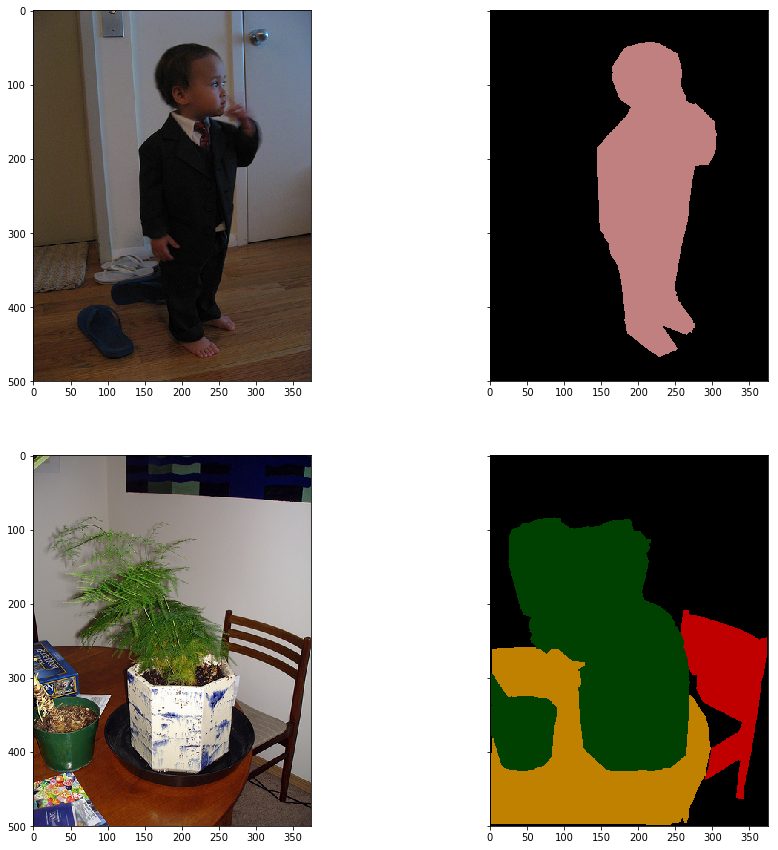

In [3]:
voc = VOC('train')
f, ax = plt.subplots(2, 2, sharey=True, figsize=(15,15))
for i in range(2):
    img, mask = voc.__getitem__(np.random.randint(0,8000 + 1), convert_mask = True)
    ax[i,0].imshow(img)
    ax[i,1].imshow(mask)
plt.show()

### RECAP Deep Learning so far

As we learned in the prior sessions, Deep Learning has shown to be immensely powerful when performing object recognition tasks. Structurally, it consists of the following 3 core components:

1. Model architecture
1. Loss function
1. Optimization method.

**Task:** Which of the 3 components need to be adapted to change a classification model into a segmentation segmentation model? <br/>
**Answer:**
Model architecture and loss function



### Changing the VGG-Net from a classifier to a segmentation model

In the following, we will change the VGG-Net from a classifier to a segmentation model. To do so, you will change the model architecture as well as the loss function accordingly.

![grafik.png](embedded_imges/imagenet_vgg16.png)

So this is how the original VGG-Net looked like. Below, you can see a PyTorch implementation of the above representation.

In [4]:
vgg = torchvision.models.vgg16()
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

As you can see, the VGG model provided by torch is nicely split into the operations extracting **features** and those acting as the **classifier**. As we learned in the introductory talk, segmentation models can be thought of as classifying each pixel of the image in parallel. Therefore, it would be nice to maintain the HxW dimension in the classifying operations. <br/>
**Task:** Define a new sequential model that maintains spatial HxW relations for the segmenter. Make sure that output shape = input shape! for your sequential model <br/>
**Hints:** Use Convolutionary layers with appropriate Padding instead of Linear layers. A convolutionary operation with kernel-size 1x1 can serve as a per-pixel classifier.

In [7]:
class Segmenter(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Segmenter, self).__init__()
        
        # extract features from VGG as shown above
        vgg = torchvision.models.vgg16()
        if pretrained:
                vgg.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth'))
        features = list(vgg.features.children())
        
        self.features = nn.Sequential(*features)        
        
        self.segmenter = nn.Sequential(
            nn.Conv2d(512,4096,7, padding=3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(4096,4096,1,1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes,1,1),
            nn.ReLU(),
            nn.Dropout()
        )
        
    def forward(self, x):
        #your forward call comes here
        return self.segmenter(self.features(x))
        

Let's check the model architecture!

In [8]:
# PASCAL VOC contains 20 classes + 1 ignore label == 21 classes in total
model = Segmenter(num_classes = 21).cuda()
print(model)

Segmenter(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): 

Let's also check what the model output shape is.

In [9]:
#remember, torch expects tensors of shape NxCxHxW
shape = (1,3,180,180)
print(model.forward(Variable(torch.Tensor(np.ones(shape=shape,dtype=np.float32))).cuda()).size())

torch.Size([1, 21, 5, 5])


Our model should now output tensors with HxW = 10 instead of the 1x1 for the classifier (if it doesn't and you fed shape of (1,3,320,320) into the model, check your model definition!). However, the shape is still far too coarse to directly compare to the input segmentation mask. <br/>
**Task:** What parameters determine the output shape in HxW dimension of your model?  Try changing some of your parameters, or even the input shape <br/>
**Answer**:
conv kernel size, conv padding, conv stride, max pool kernel size, maxpool stride, #pool-layer, #conv-layer(if padding!=(kernel size-1)/2)


If you have played around with the Input shape, you may have seen that an output is generated for any HxW shape, one major advantage of Fully Convolutional Networks (FCNs) compared to those using Fully Connected Layers!
However, while your initial segmenter is capable of generating 2-D output, its output HxW dimension are way smaller than those of the image we fed into it. Therefore, we need to somehow interpolate the original input from this dense map. <br/>
**Task:** How could this be done? <br/>
**Answer**: bilinear interpolation, transposed convolutions, upsampling, 



In Deep Learning, a neat operation exists, the Transposed Convolution. In its essence, it pads the input BEFORE performing the normal convolution operation on it. By choosing the padding in between the input(blue), kernel_size and stride accordingly, upscaling can be performed. If desired, the kernel weights are again learnable. Neat!

<img src = 'embedded_imges/padding_strides_transposed.gif'>

**Task** Modify your segmenter by adding Transposed Convolution (nn.ConvTranspose2d) for interpolation so that the output  size matches input size for input of shape (1,3,320,320). <br/>
**Hints**:
1. The output shape of the nn.ConvTranspose2d is given by <br/>
Input: $(N, C_{in}, H_{in}, W_{in})$ <br/>
Output: $(N,C_{out},H_{out},W_{out})$ <br/>
where $H_{out}=(H_{in}−1)∗stride[0]−2∗padding[0]+kernel\_size[0]+output\_padding[0]$  
$W_{out}=(W_{in}−1)∗stride[1]−2∗padding[1]+kernel\_size[1]+output\_padding[1]$ <br/>

2. Dimensionality reduction is only performed by the MaxPool layers. In total dimensionality is reduced by a factor of $2^{5}=32$. Therefore, stride of nn.ConvTranspose2d should be set to 32 so that the spatial distance between the upsampled features is kept the same.

56


In [11]:
class Segmenter(nn.Module):
    def __init__(self, num_classes, pretrained=True):
        super(Segmenter, self).__init__()
        
        # extract features from VGG as shown above
        vgg = torchvision.models.vgg16()
        if pretrained:
                vgg.load_state_dict(model_zoo.load_url('https://download.pytorch.org/models/vgg16-397923af.pth'))
        features, classifier = list(vgg.features.children()), list(vgg.classifier.children())
        
        self.features = nn.Sequential(*features)        
    
        #self.segmenter = nn.Sequential(
        #copy your Segmenter from above here
        
        #)
        self.segmenter = nn.Sequential(
            nn.Conv2d(512,4096,7, padding=3),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(4096,4096,1,1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(4096, num_classes,1,1),
            nn.ReLU(),
            nn.Dropout(),
            nn.ConvTranspose2d(num_classes, num_classes, kernel_size=64, stride=32, padding=16),
            
        )
        
        self.segmenter[-1].weight.data.copy_(get_upsampling_weight(num_classes, num_classes, kernel_size=64))
                       
        """ 
        as we are short on training time, we need to initialize our interpolator weights to perform bilinear interpolation
        for a fast convergence.
        Do this using the get_upsampling_weight(no_input features, no_output features, kernel_size) function.
        You can change the weights of a torch layer by calling its .weight.data.copy_() function.
        """
    def forward(self, x):
        #your forward call comes here
        return self.segmenter(self.features(x))
model = Segmenter(num_classes = 21)
shape = (1,3,320,320)
print(model.forward(Variable(torch.Tensor(np.ones(shape=shape,dtype=np.float32)))).size())

torch.Size([1, 21, 320, 320])


Our model is now able to learn interpolation from the [1, 21, 10, 10] predicted segmentation to the [1,21,320,320] sized input segmentation!. The next step is to train our model for a little bit and see what the output is. This is done by using the train module we provide you. In this train module, the model is trained with SGD using the specifications below. It does so by iterating over the contents of the VOC dataloader, optimizing the loss given by *nn.CrossEntropyLoss*. After every epoch, it uses the validation set of VOC for validation, printing averages for loss, ACCuracy, mean ACCuracy of all CLaSses, mean Intersection over Union and Frequency Weighted ACCuracy. It furthermore returns validation images that can be displyed for visualization purposes.

In [12]:
args = {
    'epoch_num': 10,
    'lr': 1e-10,
    'weight_decay': 1e-4,
    'momentum': 0.95,
    'lr_patience': 100,  # large patience denotes fixed lr
    'snapshot': '',  # empty string denotes learning from scratch
    'print_freq': 20,
    'val_save_to_img_file': False,
    'val_img_sample_rate': 0.1  # randomly sample some validation results to display
}
imges = train.main(train_args=args, model=model)

{'epoch_num': 10, 'lr': 1e-10, 'weight_decay': 0.0001, 'momentum': 0.95, 'lr_patience': 100, 'snapshot': '', 'print_freq': 20, 'val_save_to_img_file': False, 'val_img_sample_rate': 0.1}


/usr/local/anaconda3/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


[epoch 1], [iter 20 / 8498], [train loss 309400.65625]
[epoch 1], [iter 40 / 8498], [train loss 307104.71875]
[epoch 1], [iter 60 / 8498], [train loss 302818.56250]
[epoch 1], [iter 80 / 8498], [train loss 300173.65625]
[epoch 1], [iter 100 / 8498], [train loss 295946.46875]
[epoch 1], [iter 120 / 8498], [train loss 293641.93750]
[epoch 1], [iter 140 / 8498], [train loss 290886.37500]
[epoch 1], [iter 160 / 8498], [train loss 287016.25000]
[epoch 1], [iter 180 / 8498], [train loss 282874.00000]
[epoch 1], [iter 200 / 8498], [train loss 281684.43750]
[epoch 1], [iter 1580 / 8498], [train loss 242864.82812]
[epoch 1], [iter 1600 / 8498], [train loss 242816.64062]
[epoch 1], [iter 1620 / 8498], [train loss 242369.32812]
[epoch 1], [iter 1640 / 8498], [train loss 242297.71875]
[epoch 1], [iter 1660 / 8498], [train loss 242025.79688]
[epoch 1], [iter 1680 / 8498], [train loss 241763.25000]
[epoch 1], [iter 1700 / 8498], [train loss 241492.12500]
[epoch 1], [iter 1720 / 8498], [train loss 24

[epoch 1], [iter 4260 / 8498], [train loss 209482.79688]
[epoch 1], [iter 4280 / 8498], [train loss 209311.67188]
[epoch 1], [iter 4300 / 8498], [train loss 209118.35938]
[epoch 1], [iter 4320 / 8498], [train loss 208983.82812]
[epoch 1], [iter 4340 / 8498], [train loss 208757.64062]
[epoch 1], [iter 4360 / 8498], [train loss 208724.03125]
[epoch 1], [iter 4380 / 8498], [train loss 208538.26562]
[epoch 1], [iter 4400 / 8498], [train loss 208394.18750]
[epoch 1], [iter 4420 / 8498], [train loss 208254.90625]
[epoch 1], [iter 4440 / 8498], [train loss 208048.78125]
[epoch 1], [iter 4460 / 8498], [train loss 207846.21875]
[epoch 1], [iter 4480 / 8498], [train loss 207579.21875]
[epoch 1], [iter 4500 / 8498], [train loss 207486.95312]
[epoch 1], [iter 4520 / 8498], [train loss 207339.23438]
[epoch 1], [iter 4540 / 8498], [train loss 207117.17188]
[epoch 1], [iter 4560 / 8498], [train loss 206937.09375]
[epoch 1], [iter 4580 / 8498], [train loss 206845.17188]
[epoch 1], [iter 4600 / 8498], 

[epoch 1], [iter 7140 / 8498], [train loss 190636.43750]
[epoch 1], [iter 7160 / 8498], [train loss 190557.96875]
[epoch 1], [iter 7180 / 8498], [train loss 190443.12500]
[epoch 1], [iter 7200 / 8498], [train loss 190360.90625]
[epoch 1], [iter 7220 / 8498], [train loss 190304.03125]
[epoch 1], [iter 7240 / 8498], [train loss 190222.70312]
[epoch 1], [iter 7260 / 8498], [train loss 190047.51562]
[epoch 1], [iter 7280 / 8498], [train loss 189929.15625]
[epoch 1], [iter 7300 / 8498], [train loss 189823.17188]
[epoch 1], [iter 7320 / 8498], [train loss 189753.96875]
[epoch 1], [iter 7340 / 8498], [train loss 189635.21875]
[epoch 1], [iter 7360 / 8498], [train loss 189569.09375]
[epoch 1], [iter 7380 / 8498], [train loss 189476.70312]
[epoch 1], [iter 7400 / 8498], [train loss 189459.51562]
[epoch 1], [iter 7420 / 8498], [train loss 189412.50000]
[epoch 1], [iter 7440 / 8498], [train loss 189279.73438]
[epoch 1], [iter 7460 / 8498], [train loss 189131.26562]
[epoch 1], [iter 7480 / 8498], 

[epoch 2], [iter 1440 / 8498], [train loss 149624.45312]
[epoch 2], [iter 1460 / 8498], [train loss 149510.76562]
[epoch 2], [iter 1480 / 8498], [train loss 149515.10938]
[epoch 2], [iter 1500 / 8498], [train loss 149287.81250]
[epoch 2], [iter 1520 / 8498], [train loss 149064.70312]
[epoch 2], [iter 1540 / 8498], [train loss 149007.48438]
[epoch 2], [iter 1560 / 8498], [train loss 148961.60938]
[epoch 2], [iter 1580 / 8498], [train loss 148767.15625]
[epoch 2], [iter 1600 / 8498], [train loss 148907.14062]
[epoch 2], [iter 1620 / 8498], [train loss 148992.04688]
[epoch 2], [iter 1640 / 8498], [train loss 149095.65625]
[epoch 2], [iter 1660 / 8498], [train loss 148960.92188]
[epoch 2], [iter 1680 / 8498], [train loss 149115.04688]
[epoch 2], [iter 1700 / 8498], [train loss 149197.32812]
[epoch 2], [iter 1720 / 8498], [train loss 149227.87500]
[epoch 2], [iter 1740 / 8498], [train loss 149039.96875]
[epoch 2], [iter 1760 / 8498], [train loss 148938.73438]
[epoch 2], [iter 1780 / 8498], 

[epoch 2], [iter 4320 / 8498], [train loss 145708.12500]
[epoch 2], [iter 4340 / 8498], [train loss 145631.37500]
[epoch 2], [iter 4360 / 8498], [train loss 145623.32812]
[epoch 2], [iter 4380 / 8498], [train loss 145711.01562]
[epoch 2], [iter 4400 / 8498], [train loss 145679.65625]
[epoch 2], [iter 4420 / 8498], [train loss 145673.40625]
[epoch 2], [iter 4440 / 8498], [train loss 145718.96875]
[epoch 2], [iter 4460 / 8498], [train loss 145718.25000]
[epoch 2], [iter 4480 / 8498], [train loss 145626.42188]
[epoch 2], [iter 4500 / 8498], [train loss 145535.26562]
[epoch 2], [iter 4520 / 8498], [train loss 145459.43750]
[epoch 2], [iter 4540 / 8498], [train loss 145448.29688]
[epoch 2], [iter 4560 / 8498], [train loss 145460.14062]
[epoch 2], [iter 4580 / 8498], [train loss 145395.45312]
[epoch 2], [iter 4600 / 8498], [train loss 145319.53125]
[epoch 2], [iter 4620 / 8498], [train loss 145365.00000]
[epoch 2], [iter 4640 / 8498], [train loss 145472.51562]
[epoch 2], [iter 4660 / 8498], 

[epoch 2], [iter 7200 / 8498], [train loss 142348.03125]
[epoch 2], [iter 7220 / 8498], [train loss 142402.07812]
[epoch 2], [iter 7240 / 8498], [train loss 142364.50000]
[epoch 2], [iter 7260 / 8498], [train loss 142401.54688]
[epoch 2], [iter 7280 / 8498], [train loss 142360.53125]
[epoch 2], [iter 7300 / 8498], [train loss 142343.54688]
[epoch 2], [iter 7320 / 8498], [train loss 142298.73438]
[epoch 2], [iter 7340 / 8498], [train loss 142251.46875]
[epoch 2], [iter 7360 / 8498], [train loss 142240.71875]
[epoch 2], [iter 7380 / 8498], [train loss 142313.20312]
[epoch 2], [iter 7400 / 8498], [train loss 142222.98438]
[epoch 2], [iter 7420 / 8498], [train loss 142206.35938]
[epoch 2], [iter 7440 / 8498], [train loss 142138.00000]
[epoch 2], [iter 7460 / 8498], [train loss 142093.90625]
[epoch 2], [iter 7480 / 8498], [train loss 142049.21875]
[epoch 2], [iter 7500 / 8498], [train loss 142066.51562]
[epoch 2], [iter 7520 / 8498], [train loss 142000.18750]
[epoch 2], [iter 7540 / 8498], 

[epoch 3], [iter 1500 / 8498], [train loss 131673.06250]
[epoch 3], [iter 1520 / 8498], [train loss 131582.21875]
[epoch 3], [iter 1540 / 8498], [train loss 131495.10938]
[epoch 3], [iter 1560 / 8498], [train loss 131412.56250]
[epoch 3], [iter 1580 / 8498], [train loss 131320.31250]
[epoch 3], [iter 1600 / 8498], [train loss 131173.85938]
[epoch 3], [iter 1620 / 8498], [train loss 131143.48438]
[epoch 3], [iter 1640 / 8498], [train loss 131516.40625]
[epoch 3], [iter 1660 / 8498], [train loss 131470.57812]
[epoch 3], [iter 1680 / 8498], [train loss 131459.42188]
[epoch 3], [iter 1700 / 8498], [train loss 131290.29688]
[epoch 3], [iter 1720 / 8498], [train loss 131403.82812]
[epoch 3], [iter 1740 / 8498], [train loss 131392.43750]
[epoch 3], [iter 1760 / 8498], [train loss 131361.50000]
[epoch 3], [iter 1780 / 8498], [train loss 131328.29688]
[epoch 3], [iter 1800 / 8498], [train loss 131411.82812]
[epoch 3], [iter 1820 / 8498], [train loss 131196.67188]
[epoch 3], [iter 1840 / 8498], 

[epoch 3], [iter 4380 / 8498], [train loss 129085.25000]
[epoch 3], [iter 4400 / 8498], [train loss 128911.89844]
[epoch 3], [iter 4420 / 8498], [train loss 128852.75000]
[epoch 3], [iter 4440 / 8498], [train loss 128780.15625]
[epoch 3], [iter 4460 / 8498], [train loss 128774.78125]
[epoch 3], [iter 4480 / 8498], [train loss 128795.72656]
[epoch 3], [iter 4500 / 8498], [train loss 128790.79688]
[epoch 3], [iter 4520 / 8498], [train loss 128751.85938]
[epoch 3], [iter 4540 / 8498], [train loss 128676.48438]
[epoch 3], [iter 4560 / 8498], [train loss 128751.62500]
[epoch 3], [iter 4580 / 8498], [train loss 128681.35156]
[epoch 3], [iter 4600 / 8498], [train loss 128717.09375]
[epoch 3], [iter 4620 / 8498], [train loss 128764.64844]
[epoch 3], [iter 4640 / 8498], [train loss 128810.38281]
[epoch 3], [iter 4660 / 8498], [train loss 128730.94531]
[epoch 3], [iter 4680 / 8498], [train loss 128725.55469]
[epoch 3], [iter 4700 / 8498], [train loss 128823.73438]
[epoch 3], [iter 4720 / 8498], 

[epoch 3], [iter 7260 / 8498], [train loss 127320.39062]
[epoch 3], [iter 7280 / 8498], [train loss 127257.31250]
[epoch 3], [iter 7300 / 8498], [train loss 127230.72656]
[epoch 3], [iter 7320 / 8498], [train loss 127234.80469]
[epoch 3], [iter 7340 / 8498], [train loss 127221.28125]
[epoch 3], [iter 7360 / 8498], [train loss 127226.14844]
[epoch 3], [iter 7380 / 8498], [train loss 127228.65625]
[epoch 3], [iter 7400 / 8498], [train loss 127223.94531]
[epoch 3], [iter 7420 / 8498], [train loss 127248.89062]
[epoch 3], [iter 7440 / 8498], [train loss 127220.62500]
[epoch 3], [iter 7460 / 8498], [train loss 127182.98438]
[epoch 3], [iter 7480 / 8498], [train loss 127097.95312]
[epoch 3], [iter 7500 / 8498], [train loss 127060.60938]
[epoch 3], [iter 7520 / 8498], [train loss 127016.71875]
[epoch 3], [iter 7540 / 8498], [train loss 126930.47656]
[epoch 3], [iter 7560 / 8498], [train loss 126911.75781]
[epoch 3], [iter 7580 / 8498], [train loss 126919.50000]
[epoch 3], [iter 7600 / 8498], 

[epoch 4], [iter 1560 / 8498], [train loss 119148.68750]
[epoch 4], [iter 1580 / 8498], [train loss 119271.46094]
[epoch 4], [iter 1600 / 8498], [train loss 119372.84375]
[epoch 4], [iter 1620 / 8498], [train loss 119336.54688]
[epoch 4], [iter 1640 / 8498], [train loss 119484.06250]
[epoch 4], [iter 1660 / 8498], [train loss 119286.05469]
[epoch 4], [iter 1680 / 8498], [train loss 119583.17969]
[epoch 4], [iter 1700 / 8498], [train loss 119581.30469]
[epoch 4], [iter 1720 / 8498], [train loss 119545.28125]
[epoch 4], [iter 1740 / 8498], [train loss 119699.10938]
[epoch 4], [iter 1760 / 8498], [train loss 119482.00781]
[epoch 4], [iter 1780 / 8498], [train loss 119426.53906]
[epoch 4], [iter 1800 / 8498], [train loss 119479.83594]
[epoch 4], [iter 1820 / 8498], [train loss 119818.90625]
[epoch 4], [iter 1840 / 8498], [train loss 119783.28125]
[epoch 4], [iter 1860 / 8498], [train loss 119633.78906]
[epoch 4], [iter 1880 / 8498], [train loss 119497.20312]
[epoch 4], [iter 1900 / 8498], 

[epoch 4], [iter 4440 / 8498], [train loss 118778.09375]
[epoch 4], [iter 4460 / 8498], [train loss 118685.95312]
[epoch 4], [iter 4480 / 8498], [train loss 118723.63281]
[epoch 4], [iter 4500 / 8498], [train loss 118688.00781]
[epoch 4], [iter 4520 / 8498], [train loss 118611.46875]
[epoch 4], [iter 4540 / 8498], [train loss 118583.53125]
[epoch 4], [iter 4560 / 8498], [train loss 118524.78906]
[epoch 4], [iter 4580 / 8498], [train loss 118587.46094]
[epoch 4], [iter 4600 / 8498], [train loss 118492.21875]
[epoch 4], [iter 4620 / 8498], [train loss 118525.02344]
[epoch 4], [iter 4640 / 8498], [train loss 118404.74219]
[epoch 4], [iter 4660 / 8498], [train loss 118523.57812]
[epoch 4], [iter 4680 / 8498], [train loss 118519.86719]
[epoch 4], [iter 4700 / 8498], [train loss 118429.17969]
[epoch 4], [iter 4720 / 8498], [train loss 118352.55469]
[epoch 4], [iter 4740 / 8498], [train loss 118322.50000]
[epoch 4], [iter 4760 / 8498], [train loss 118350.58594]
[epoch 4], [iter 4780 / 8498], 

[epoch 4], [iter 7320 / 8498], [train loss 117343.60938]
[epoch 4], [iter 7340 / 8498], [train loss 117402.46875]
[epoch 4], [iter 7360 / 8498], [train loss 117466.75000]
[epoch 4], [iter 7380 / 8498], [train loss 117409.60938]
[epoch 4], [iter 7400 / 8498], [train loss 117414.97656]
[epoch 4], [iter 7420 / 8498], [train loss 117412.65625]
[epoch 4], [iter 7440 / 8498], [train loss 117379.99219]
[epoch 4], [iter 7460 / 8498], [train loss 117349.93750]
[epoch 4], [iter 7480 / 8498], [train loss 117399.46875]
[epoch 4], [iter 7500 / 8498], [train loss 117371.53125]
[epoch 4], [iter 7520 / 8498], [train loss 117326.15625]
[epoch 4], [iter 7540 / 8498], [train loss 117343.02344]
[epoch 4], [iter 7560 / 8498], [train loss 117305.81250]
[epoch 4], [iter 7580 / 8498], [train loss 117305.93750]
[epoch 4], [iter 7600 / 8498], [train loss 117340.39062]
[epoch 4], [iter 7620 / 8498], [train loss 117323.48438]
[epoch 4], [iter 7640 / 8498], [train loss 117267.57031]
[epoch 4], [iter 7660 / 8498], 

[epoch 5], [iter 1620 / 8498], [train loss 116353.18750]
[epoch 5], [iter 1640 / 8498], [train loss 116386.07812]
[epoch 5], [iter 1660 / 8498], [train loss 116333.53125]
[epoch 5], [iter 1680 / 8498], [train loss 116418.79688]
[epoch 5], [iter 1700 / 8498], [train loss 116261.26562]
[epoch 5], [iter 1720 / 8498], [train loss 116117.96094]
[epoch 5], [iter 1740 / 8498], [train loss 116138.85156]
[epoch 5], [iter 1760 / 8498], [train loss 116096.75781]
[epoch 5], [iter 1780 / 8498], [train loss 115817.17969]
[epoch 5], [iter 1800 / 8498], [train loss 115766.82812]
[epoch 5], [iter 1820 / 8498], [train loss 115523.58594]
[epoch 5], [iter 1840 / 8498], [train loss 115292.78125]
[epoch 5], [iter 1860 / 8498], [train loss 115063.78906]
[epoch 5], [iter 1880 / 8498], [train loss 114970.46094]
[epoch 5], [iter 1900 / 8498], [train loss 115028.50781]
[epoch 5], [iter 1920 / 8498], [train loss 114951.81250]
[epoch 5], [iter 1940 / 8498], [train loss 114903.95312]
[epoch 5], [iter 1960 / 8498], 

[epoch 5], [iter 4500 / 8498], [train loss 113330.65625]
[epoch 5], [iter 4520 / 8498], [train loss 113326.49219]
[epoch 5], [iter 4540 / 8498], [train loss 113352.18750]
[epoch 5], [iter 4560 / 8498], [train loss 113345.68750]
[epoch 5], [iter 4580 / 8498], [train loss 113281.24219]
[epoch 5], [iter 4600 / 8498], [train loss 113211.48438]
[epoch 5], [iter 4620 / 8498], [train loss 113378.41406]
[epoch 5], [iter 4640 / 8498], [train loss 113365.65625]
[epoch 5], [iter 4660 / 8498], [train loss 113406.50781]
[epoch 5], [iter 4680 / 8498], [train loss 113375.22656]
[epoch 5], [iter 4700 / 8498], [train loss 113296.09375]
[epoch 5], [iter 4720 / 8498], [train loss 113226.55469]
[epoch 5], [iter 4740 / 8498], [train loss 113153.20312]
[epoch 5], [iter 4760 / 8498], [train loss 113090.21875]
[epoch 5], [iter 4780 / 8498], [train loss 113069.51562]
[epoch 5], [iter 4800 / 8498], [train loss 113068.33594]
[epoch 5], [iter 4820 / 8498], [train loss 112968.86719]
[epoch 5], [iter 4840 / 8498], 

[epoch 5], [iter 7380 / 8498], [train loss 110925.21094]
[epoch 5], [iter 7400 / 8498], [train loss 110990.57812]
[epoch 5], [iter 7420 / 8498], [train loss 110990.35156]
[epoch 5], [iter 7440 / 8498], [train loss 110974.35938]
[epoch 5], [iter 7460 / 8498], [train loss 110967.93750]
[epoch 5], [iter 7480 / 8498], [train loss 110980.03125]
[epoch 5], [iter 7500 / 8498], [train loss 110979.63281]
[epoch 5], [iter 7520 / 8498], [train loss 110926.42188]
[epoch 5], [iter 7540 / 8498], [train loss 110957.62500]
[epoch 5], [iter 7560 / 8498], [train loss 110940.32031]
[epoch 5], [iter 7580 / 8498], [train loss 110925.80469]
[epoch 5], [iter 7600 / 8498], [train loss 110961.17969]
[epoch 5], [iter 7620 / 8498], [train loss 110946.78906]
[epoch 5], [iter 7640 / 8498], [train loss 110919.28125]
[epoch 5], [iter 7660 / 8498], [train loss 110922.97656]
[epoch 5], [iter 7680 / 8498], [train loss 110887.82812]
[epoch 5], [iter 7700 / 8498], [train loss 110888.49219]
[epoch 5], [iter 7720 / 8498], 

[epoch 6], [iter 1680 / 8498], [train loss 105264.24219]
[epoch 6], [iter 1700 / 8498], [train loss 105116.83594]
[epoch 6], [iter 1720 / 8498], [train loss 105147.28906]
[epoch 6], [iter 1740 / 8498], [train loss 105388.53125]
[epoch 6], [iter 1760 / 8498], [train loss 105157.02344]
[epoch 6], [iter 1780 / 8498], [train loss 105100.07031]
[epoch 6], [iter 1800 / 8498], [train loss 104985.31250]
[epoch 6], [iter 1820 / 8498], [train loss 104928.99219]
[epoch 6], [iter 1840 / 8498], [train loss 105051.43750]
[epoch 6], [iter 1860 / 8498], [train loss 105440.28125]
[epoch 6], [iter 1880 / 8498], [train loss 105576.69531]
[epoch 6], [iter 1900 / 8498], [train loss 105605.85938]
[epoch 6], [iter 1920 / 8498], [train loss 105565.39062]
[epoch 6], [iter 1940 / 8498], [train loss 105340.25781]
[epoch 6], [iter 1960 / 8498], [train loss 105240.54688]
[epoch 6], [iter 1980 / 8498], [train loss 105165.52344]
[epoch 6], [iter 2000 / 8498], [train loss 105098.10938]
[epoch 6], [iter 2020 / 8498], 

[epoch 6], [iter 4560 / 8498], [train loss 105368.24219]
[epoch 6], [iter 4580 / 8498], [train loss 105305.96875]
[epoch 6], [iter 4600 / 8498], [train loss 105326.19531]
[epoch 6], [iter 4620 / 8498], [train loss 105261.31250]
[epoch 6], [iter 4640 / 8498], [train loss 105306.54688]
[epoch 6], [iter 4660 / 8498], [train loss 105170.76562]
[epoch 6], [iter 4680 / 8498], [train loss 105120.91406]
[epoch 6], [iter 4700 / 8498], [train loss 105083.61719]
[epoch 6], [iter 4720 / 8498], [train loss 105223.85938]
[epoch 6], [iter 4740 / 8498], [train loss 105207.07031]
[epoch 6], [iter 4760 / 8498], [train loss 105238.41406]
[epoch 6], [iter 4780 / 8498], [train loss 105264.42188]
[epoch 6], [iter 4800 / 8498], [train loss 105287.78906]
[epoch 6], [iter 4820 / 8498], [train loss 105333.07031]
[epoch 6], [iter 4840 / 8498], [train loss 105401.69531]
[epoch 6], [iter 4860 / 8498], [train loss 105530.37500]
[epoch 6], [iter 4880 / 8498], [train loss 105590.74219]
[epoch 6], [iter 4900 / 8498], 

[epoch 6], [iter 7440 / 8498], [train loss 105706.57812]
[epoch 6], [iter 7460 / 8498], [train loss 105774.46094]
[epoch 6], [iter 7480 / 8498], [train loss 105788.41406]
[epoch 6], [iter 7500 / 8498], [train loss 105725.36719]
[epoch 6], [iter 7520 / 8498], [train loss 105671.48438]
[epoch 6], [iter 7540 / 8498], [train loss 105761.54688]
[epoch 6], [iter 7560 / 8498], [train loss 105724.52344]
[epoch 6], [iter 7580 / 8498], [train loss 105779.86719]
[epoch 6], [iter 7600 / 8498], [train loss 105800.75781]
[epoch 6], [iter 7620 / 8498], [train loss 105849.26562]
[epoch 6], [iter 7640 / 8498], [train loss 105845.50000]
[epoch 6], [iter 7660 / 8498], [train loss 105862.79688]
[epoch 6], [iter 7680 / 8498], [train loss 105855.82031]
[epoch 6], [iter 7700 / 8498], [train loss 105840.10156]
[epoch 6], [iter 7720 / 8498], [train loss 105862.03906]
[epoch 6], [iter 7740 / 8498], [train loss 105893.56250]
[epoch 6], [iter 7760 / 8498], [train loss 105866.57812]
[epoch 6], [iter 7780 / 8498], 

[epoch 7], [iter 1740 / 8498], [train loss 103098.82031]
[epoch 7], [iter 1760 / 8498], [train loss 103117.60938]
[epoch 7], [iter 1780 / 8498], [train loss 103243.76562]
[epoch 7], [iter 1800 / 8498], [train loss 103340.61719]
[epoch 7], [iter 1820 / 8498], [train loss 103390.29688]
[epoch 7], [iter 1840 / 8498], [train loss 103276.76562]
[epoch 7], [iter 1860 / 8498], [train loss 103206.85156]
[epoch 7], [iter 1880 / 8498], [train loss 103394.85156]
[epoch 7], [iter 1900 / 8498], [train loss 103349.86719]
[epoch 7], [iter 1920 / 8498], [train loss 103200.22656]
[epoch 7], [iter 1940 / 8498], [train loss 103095.45312]
[epoch 7], [iter 1960 / 8498], [train loss 103173.93750]
[epoch 7], [iter 1980 / 8498], [train loss 103116.03906]
[epoch 7], [iter 2000 / 8498], [train loss 102907.55469]
[epoch 7], [iter 2020 / 8498], [train loss 102962.69531]
[epoch 7], [iter 2040 / 8498], [train loss 103334.81250]
[epoch 7], [iter 2060 / 8498], [train loss 103401.99219]
[epoch 7], [iter 2080 / 8498], 

[epoch 7], [iter 4800 / 8498], [train loss 103549.06250]
[epoch 7], [iter 4820 / 8498], [train loss 103594.14844]
[epoch 7], [iter 4840 / 8498], [train loss 103544.89062]
[epoch 7], [iter 4860 / 8498], [train loss 103505.32031]
[epoch 7], [iter 4880 / 8498], [train loss 103463.24219]
[epoch 7], [iter 4900 / 8498], [train loss 103428.19531]
[epoch 7], [iter 4920 / 8498], [train loss 103506.60938]
[epoch 7], [iter 4940 / 8498], [train loss 103414.36719]
[epoch 7], [iter 4960 / 8498], [train loss 103392.04688]
[epoch 7], [iter 4980 / 8498], [train loss 103447.89844]
[epoch 7], [iter 5000 / 8498], [train loss 103413.59375]
[epoch 7], [iter 5020 / 8498], [train loss 103431.82031]
[epoch 7], [iter 5040 / 8498], [train loss 103441.64844]
[epoch 7], [iter 5060 / 8498], [train loss 103412.25781]
[epoch 7], [iter 5080 / 8498], [train loss 103415.48438]
[epoch 7], [iter 5100 / 8498], [train loss 103452.87500]
[epoch 7], [iter 5120 / 8498], [train loss 103385.57812]
[epoch 7], [iter 5140 / 8498], 

[epoch 7], [iter 7680 / 8498], [train loss 102649.89062]
[epoch 7], [iter 7700 / 8498], [train loss 102643.47656]
[epoch 7], [iter 7720 / 8498], [train loss 102642.17188]
[epoch 7], [iter 7740 / 8498], [train loss 102672.15625]
[epoch 7], [iter 7760 / 8498], [train loss 102713.64062]
[epoch 7], [iter 7780 / 8498], [train loss 102742.25781]
[epoch 7], [iter 7800 / 8498], [train loss 102796.10156]
[epoch 7], [iter 7820 / 8498], [train loss 102805.87500]
[epoch 7], [iter 7840 / 8498], [train loss 102858.95312]
[epoch 7], [iter 7860 / 8498], [train loss 102883.46875]
[epoch 7], [iter 7880 / 8498], [train loss 102866.52344]
[epoch 7], [iter 7900 / 8498], [train loss 102873.47656]
[epoch 7], [iter 7920 / 8498], [train loss 102885.35938]
[epoch 7], [iter 7940 / 8498], [train loss 102858.40625]
[epoch 7], [iter 7960 / 8498], [train loss 102775.93750]
[epoch 7], [iter 7980 / 8498], [train loss 102836.95312]
[epoch 7], [iter 8000 / 8498], [train loss 102803.31250]
[epoch 7], [iter 8020 / 8498], 

[epoch 8], [iter 1980 / 8498], [train loss 102095.64062]
[epoch 8], [iter 2000 / 8498], [train loss 101817.46875]
[epoch 8], [iter 2020 / 8498], [train loss 101857.14844]
[epoch 8], [iter 2040 / 8498], [train loss 101827.12500]
[epoch 8], [iter 2060 / 8498], [train loss 101778.41406]
[epoch 8], [iter 2080 / 8498], [train loss 101742.41406]
[epoch 8], [iter 2100 / 8498], [train loss 101497.65625]
[epoch 8], [iter 2120 / 8498], [train loss 101366.53906]
[epoch 8], [iter 2140 / 8498], [train loss 101454.51562]
[epoch 8], [iter 2160 / 8498], [train loss 101300.19531]
[epoch 8], [iter 2180 / 8498], [train loss 101511.19531]
[epoch 8], [iter 2200 / 8498], [train loss 101317.58594]
[epoch 8], [iter 2220 / 8498], [train loss 101189.25000]
[epoch 8], [iter 2240 / 8498], [train loss 101278.88281]
[epoch 8], [iter 2260 / 8498], [train loss 101204.64844]
[epoch 8], [iter 2280 / 8498], [train loss 101004.57812]
[epoch 8], [iter 2300 / 8498], [train loss 100875.58594]
[epoch 8], [iter 2320 / 8498], 

[epoch 8], [iter 4860 / 8498], [train loss 100503.05469]
[epoch 8], [iter 4880 / 8498], [train loss 100578.21875]
[epoch 8], [iter 4900 / 8498], [train loss 100599.99219]
[epoch 8], [iter 4920 / 8498], [train loss 100458.72656]
[epoch 8], [iter 4940 / 8498], [train loss 100445.16406]
[epoch 8], [iter 4960 / 8498], [train loss 100378.69531]
[epoch 8], [iter 4980 / 8498], [train loss 100370.86719]
[epoch 8], [iter 5000 / 8498], [train loss 100403.77344]
[epoch 8], [iter 5020 / 8498], [train loss 100333.35938]
[epoch 8], [iter 5040 / 8498], [train loss 100378.85156]
[epoch 8], [iter 5060 / 8498], [train loss 100318.15625]
[epoch 8], [iter 5080 / 8498], [train loss 100262.21875]
[epoch 8], [iter 5100 / 8498], [train loss 100255.46875]
[epoch 8], [iter 5120 / 8498], [train loss 100215.89062]
[epoch 8], [iter 5140 / 8498], [train loss 100120.70312]
[epoch 8], [iter 5160 / 8498], [train loss 100086.11719]
[epoch 8], [iter 5180 / 8498], [train loss 100061.83594]
[epoch 8], [iter 5200 / 8498], 

[epoch 8], [iter 7740 / 8498], [train loss 100489.67188]
[epoch 8], [iter 7760 / 8498], [train loss 100492.02344]
[epoch 8], [iter 7780 / 8498], [train loss 100447.36719]
[epoch 8], [iter 7800 / 8498], [train loss 100432.54688]
[epoch 8], [iter 7820 / 8498], [train loss 100388.99219]
[epoch 8], [iter 7840 / 8498], [train loss 100392.28125]
[epoch 8], [iter 7860 / 8498], [train loss 100346.00781]
[epoch 8], [iter 7880 / 8498], [train loss 100385.16406]
[epoch 8], [iter 7900 / 8498], [train loss 100407.39062]
[epoch 8], [iter 7920 / 8498], [train loss 100439.67188]
[epoch 8], [iter 7940 / 8498], [train loss 100509.28125]
[epoch 8], [iter 7960 / 8498], [train loss 100472.25000]
[epoch 8], [iter 7980 / 8498], [train loss 100446.42969]
[epoch 8], [iter 8000 / 8498], [train loss 100431.53125]
[epoch 8], [iter 8020 / 8498], [train loss 100434.50000]
[epoch 8], [iter 8040 / 8498], [train loss 100517.48438]
[epoch 8], [iter 8060 / 8498], [train loss 100539.00000]
[epoch 8], [iter 8080 / 8498], 

[epoch 9], [iter 2060 / 8498], [train loss 98848.55469]
[epoch 9], [iter 2080 / 8498], [train loss 98880.61719]
[epoch 9], [iter 2100 / 8498], [train loss 98866.97656]
[epoch 9], [iter 2120 / 8498], [train loss 98766.37500]
[epoch 9], [iter 2140 / 8498], [train loss 98857.90625]
[epoch 9], [iter 2160 / 8498], [train loss 98777.85938]
[epoch 9], [iter 2180 / 8498], [train loss 98979.66406]
[epoch 9], [iter 2200 / 8498], [train loss 98954.13281]
[epoch 9], [iter 2220 / 8498], [train loss 99079.28906]
[epoch 9], [iter 2240 / 8498], [train loss 99268.21094]
[epoch 9], [iter 2260 / 8498], [train loss 99444.25000]
[epoch 9], [iter 2280 / 8498], [train loss 99437.88281]
[epoch 9], [iter 2300 / 8498], [train loss 99344.29688]
[epoch 9], [iter 2320 / 8498], [train loss 99418.73438]
[epoch 9], [iter 2340 / 8498], [train loss 99367.25781]
[epoch 9], [iter 2360 / 8498], [train loss 99293.85156]
[epoch 9], [iter 2380 / 8498], [train loss 99492.17188]
[epoch 9], [iter 2400 / 8498], [train loss 99400

[epoch 9], [iter 5000 / 8498], [train loss 98216.75000]
[epoch 9], [iter 5020 / 8498], [train loss 98178.58594]
[epoch 9], [iter 5040 / 8498], [train loss 98195.58594]
[epoch 9], [iter 5060 / 8498], [train loss 98266.38281]
[epoch 9], [iter 5080 / 8498], [train loss 98321.13281]
[epoch 9], [iter 5100 / 8498], [train loss 98375.21875]
[epoch 9], [iter 5120 / 8498], [train loss 98416.98438]
[epoch 9], [iter 5140 / 8498], [train loss 98468.13281]
[epoch 9], [iter 5160 / 8498], [train loss 98413.17188]
[epoch 9], [iter 5180 / 8498], [train loss 98396.68750]
[epoch 9], [iter 5200 / 8498], [train loss 98448.20312]
[epoch 9], [iter 5220 / 8498], [train loss 98415.57812]
[epoch 9], [iter 5240 / 8498], [train loss 98393.83594]
[epoch 9], [iter 5260 / 8498], [train loss 98318.29688]
[epoch 9], [iter 5280 / 8498], [train loss 98335.51562]
[epoch 9], [iter 5300 / 8498], [train loss 98382.49219]
[epoch 9], [iter 5320 / 8498], [train loss 98307.36719]
[epoch 9], [iter 5340 / 8498], [train loss 98323

[epoch 9], [iter 7940 / 8498], [train loss 98151.94531]
[epoch 9], [iter 7960 / 8498], [train loss 98169.31250]
[epoch 9], [iter 7980 / 8498], [train loss 98201.75000]
[epoch 9], [iter 8000 / 8498], [train loss 98189.25781]
[epoch 9], [iter 8020 / 8498], [train loss 98206.31250]
[epoch 9], [iter 8040 / 8498], [train loss 98162.80469]
[epoch 9], [iter 8060 / 8498], [train loss 98201.92188]
[epoch 9], [iter 8080 / 8498], [train loss 98234.00000]
[epoch 9], [iter 8100 / 8498], [train loss 98202.56250]
[epoch 9], [iter 8120 / 8498], [train loss 98268.67969]
[epoch 9], [iter 8140 / 8498], [train loss 98218.79688]
[epoch 9], [iter 8160 / 8498], [train loss 98236.23438]
[epoch 9], [iter 8180 / 8498], [train loss 98267.51562]
[epoch 9], [iter 8200 / 8498], [train loss 98272.30469]
[epoch 9], [iter 8220 / 8498], [train loss 98341.57031]
[epoch 9], [iter 8240 / 8498], [train loss 98357.75781]
[epoch 9], [iter 8260 / 8498], [train loss 98404.71094]
[epoch 9], [iter 8280 / 8498], [train loss 98418

[epoch 10], [iter 2240 / 8498], [train loss 97571.60156]
[epoch 10], [iter 2260 / 8498], [train loss 97515.14062]
[epoch 10], [iter 2280 / 8498], [train loss 97442.85938]
[epoch 10], [iter 2300 / 8498], [train loss 97455.22656]
[epoch 10], [iter 2320 / 8498], [train loss 97439.18750]
[epoch 10], [iter 2340 / 8498], [train loss 97473.75000]
[epoch 10], [iter 2360 / 8498], [train loss 97712.97656]
[epoch 10], [iter 2380 / 8498], [train loss 97769.71875]
[epoch 10], [iter 2400 / 8498], [train loss 97769.34375]
[epoch 10], [iter 2420 / 8498], [train loss 97787.98438]
[epoch 10], [iter 2440 / 8498], [train loss 97552.32812]
[epoch 10], [iter 2460 / 8498], [train loss 97614.30469]
[epoch 10], [iter 2480 / 8498], [train loss 97442.67188]
[epoch 10], [iter 2500 / 8498], [train loss 97340.82031]
[epoch 10], [iter 2520 / 8498], [train loss 97456.80469]
[epoch 10], [iter 2540 / 8498], [train loss 97353.25781]
[epoch 10], [iter 2560 / 8498], [train loss 97499.27344]
[epoch 10], [iter 2580 / 8498],

[epoch 10], [iter 5120 / 8498], [train loss 96286.20312]
[epoch 10], [iter 5140 / 8498], [train loss 96250.87500]
[epoch 10], [iter 5160 / 8498], [train loss 96179.35938]
[epoch 10], [iter 5180 / 8498], [train loss 96258.02344]
[epoch 10], [iter 5200 / 8498], [train loss 96238.21875]
[epoch 10], [iter 5220 / 8498], [train loss 96379.26562]
[epoch 10], [iter 5240 / 8498], [train loss 96331.57031]
[epoch 10], [iter 5260 / 8498], [train loss 96377.57031]
[epoch 10], [iter 5280 / 8498], [train loss 96393.78125]
[epoch 10], [iter 5300 / 8498], [train loss 96369.41406]
[epoch 10], [iter 5320 / 8498], [train loss 96425.69531]
[epoch 10], [iter 5340 / 8498], [train loss 96474.80469]
[epoch 10], [iter 5360 / 8498], [train loss 96423.25781]
[epoch 10], [iter 5380 / 8498], [train loss 96449.73438]
[epoch 10], [iter 5400 / 8498], [train loss 96500.39844]
[epoch 10], [iter 5420 / 8498], [train loss 96489.82812]
[epoch 10], [iter 5440 / 8498], [train loss 96474.92188]
[epoch 10], [iter 5460 / 8498],

[epoch 10], [iter 8000 / 8498], [train loss 96098.43750]
[epoch 10], [iter 8020 / 8498], [train loss 96121.38281]
[epoch 10], [iter 8040 / 8498], [train loss 96145.38281]
[epoch 10], [iter 8060 / 8498], [train loss 96133.66406]
[epoch 10], [iter 8080 / 8498], [train loss 96105.77344]
[epoch 10], [iter 8100 / 8498], [train loss 96086.10938]
[epoch 10], [iter 8120 / 8498], [train loss 96166.74219]
[epoch 10], [iter 8140 / 8498], [train loss 96197.32812]
[epoch 10], [iter 8160 / 8498], [train loss 96213.78125]
[epoch 10], [iter 8180 / 8498], [train loss 96173.29688]
[epoch 10], [iter 8200 / 8498], [train loss 96151.66406]
[epoch 10], [iter 8220 / 8498], [train loss 96109.27344]
[epoch 10], [iter 8240 / 8498], [train loss 96092.64062]
[epoch 10], [iter 8260 / 8498], [train loss 96123.50000]
[epoch 10], [iter 8280 / 8498], [train loss 96126.71875]
[epoch 10], [iter 8300 / 8498], [train loss 96072.10938]
[epoch 10], [iter 8320 / 8498], [train loss 96054.06250]
[epoch 10], [iter 8340 / 8498],

While the model is training, you are surely asking yourself how the nn.CrossEntropyLoss works. It's based on the Negative-Log Likelihood Loss used for classification, which is defined as follows:


$L_{pixel} = -\sum_{n=1}^My_{n}\log(p_{n})$

Where $M$ are the number of classes, and $y_n$ is equal to 1 for the true class label and 0 otherwise.

**Task:** Modify the NLL Loss from classification to segmentation. <br/>
**Hint:** Remember that segmentation can be understood as pixel-wise classification. <br/>
**Answer:**

$L = \sum_{pixel=1}^{N²}L_{pixel}$



After training has finished, let's look at some images from the validation set! Repeatedly execute the cell below to get several glimpses.

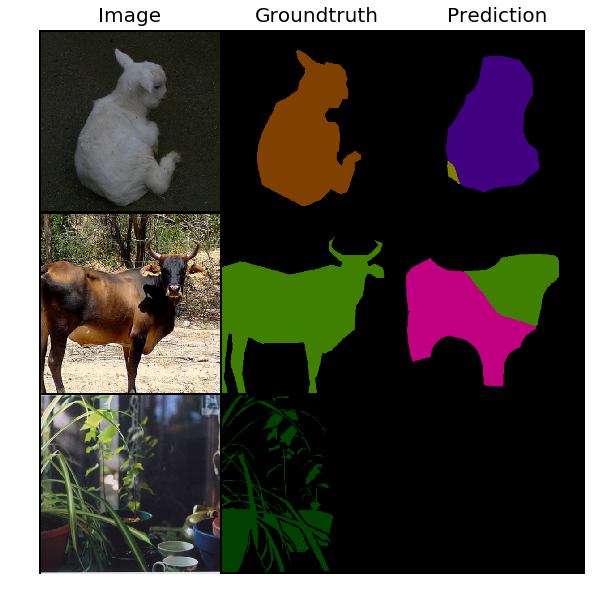

In [13]:
npimg = imges.numpy()
img_size = 405
img_to_show = 3
random = np.random.randint(0,65)
npimg = npimg[:,random*img_size:(random+img_to_show)*img_size, :]
plt.figure(figsize=(10,10))
plt.text(130,-20, 'Image', fontsize = 20)
plt.text(480,-20, 'Groundtruth', fontsize = 20)
plt.text(910,-20, 'Prediction', fontsize = 20)
plt.axis('off')

plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

When looking at your model predictions, keep in mind that we trained only for a very short time (10 min) compared to the hours to days it would take normally. In the best case scenario, something along the following lines can be achieved for the VGG-net that we adapted to segmentation.

|          []()                         |                                         |
| :----:                                | :----:                                  |
| ![grafik.png](embedded_imges/GT.PNG)  | ![grafik.png](embedded_imges/Pred.PNG)  | 
|                                       |                                         |

If you can still see the checkerboard pattern of the original (1x21x10x10) predictions in your (1x21x320x320) segmentation map, your design choice regarding the nn.ConvTranspose2d was poor. Rethink and make sure your interpolation kernel is big enough to "see" at least 2 of the original (1x21x10x10) predictions. Redesign and retrain your model!

Even under best conditions, the model prediction is way coarser than the GT annotation. The reason for this is that the input for the transposed convolution layer simply has too little spatial resolution. If we add features with higher spatial resolution to our model architecture, we achieve a segmentation like this:

![grafik.png](embedded_imges/Pred_FCN8.PNG)

**Task:** Think of ways to include features with high spatial resolution into the interpolation learned by the transposed convolution? <br/>
**Hint:** How about performing multiple transposed convolutions? Spatial resolution is reduced only upon every MaxPool layer. <br/>
**Answer:**
U-Net :)


# Additional Tasks

**Task:** Using the prior knowledge of skip connections, try to implement the U-Net, a state-of-the art Deep Learning architecture for semantic segmentation. Use the visual help for guidance! Cropping is not required since you used Padded Convolutions. Skip connections/Concatenation operations can be implemented using the *torch.cat()* function. Check for output and input shapes!

<img src = 'embedded_imges/U-Net.png' width='800'>

In [14]:
class U_Net (nn.Module):
    def __init__(self, num_classes, pretrained=True):
        #your model implementation comes here
        super(U_Net, self).__init__()
        
        self.skip1 = nn.Sequential(
            nn.Conv2d(3,64,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(64,64,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),            
        )
        input_features = 64
        self.skip2 = nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(2*input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
        )
        input_features = 128
        self.skip3 = nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(2*input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
        )
        input_features = 256
        self.skip4 = nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(2*input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
        )
        input_features = 512
        self.middle= nn.Sequential(
            nn.MaxPool2d(2,2),
            nn.Conv2d(input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(2*input_features,2*input_features,3,padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #upconv1
            nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),
            nn.Conv2d(1024,512, 1),
            nn.ReLU(),
            nn.Dropout(),
        )
        
        #expansive2 because includes second upconv
        self.expansive2 = nn.Sequential(
            nn.Conv2d(1024,512,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(512,512,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #upconv2
            nn.ConvTranspose2d(512, 512, kernel_size=2, stride=2),
            nn.Conv2d(512, 256, 1),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.expansive3 = nn.Sequential(
            nn.Conv2d(512,256,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(256,256,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #upconv3
            nn.ConvTranspose2d(256, 256, kernel_size=2, stride=2),
            nn.Conv2d(256, 128, 1),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.expansive4 = nn.Sequential(
            nn.Conv2d(256,128,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(128,128,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            #upconv4
            nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
            nn.Conv2d(128, 64, 1),
            nn.ReLU(),
            nn.Dropout(),
        )
        self.masks = nn.Sequential(
            nn.Conv2d(128,64,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(64,64,3, padding=1),
            nn.ReLU(),
            nn.Dropout(),
            nn.Conv2d(64, num_classes, 1,1)   
        )
        # ACHTUNG!
        self.middle[-4].weight.data.copy_(get_upsampling_weight(1024,1024, kernel_size=2))
        self.expansive2[-4].weight.data.copy_(get_upsampling_weight(512, 512, kernel_size=2))
        self.expansive3[-4].weight.data.copy_(get_upsampling_weight(256, 256, kernel_size=2))
        self.expansive4[-4].weight.data.copy_(get_upsampling_weight(128, 128, kernel_size=2))
                       
        
    def forward(self, x):
        #your forward call comes here
        s1 = self.skip1(x)
        s2 = self.skip2(s1)
        s3 = self.skip3(s2)
        s4 = self.skip4(s3)
        m = self.middle(s4)
        e2 = self.expansive2(torch.cat((m,s4), dim=1))
        e3 = self.expansive3(torch.cat((e2,s3), dim=1))
        e4 = self.expansive4(torch.cat((e3,s2), dim=1))
        masks = self.masks(torch.cat((e4,s1), dim=1))
        return masks

**Task:** Implement the *get_upsampling_weight(no_input features, no_output features, kernel_size)* function used to initialize the convolution kernels of the transposed convolution with a bilinear interpolation kernel.

In [15]:
def get_upsampling_weight(no_input features, no_output features, kernel_size):

SyntaxError: invalid syntax (<ipython-input-15-b7c8c27c422a>, line 1)

### Feedback

Aaaaaand we're done 👏🏼🍻

If you have any suggestions on how we could improve this session, please let us know in the following cell. What did you particularly like or dislike? Did you miss any contents?